In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn.functional import binary_cross_entropy
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
def roberts_sequence(
        num_points,
        num_dims,
        root_iters=10_000,
    ):
    """
    Creates random numbers tiling a hybercube [0, 1]^d where d is `num_dims`.

    Code modified from:
    https://gist.github.com/carlosgmartin/1fd4e60bed526ec8ae076137ded6ebab
    """

    # Compute the unique positive root of f using the Newton-Raphson method.
    def f(x):
        return x ** (num_dims + 1) - x - 1

    def grad_f(x):
        return (num_dims + 1) * (x ** num_dims) - 1

    # Main loop.
    x = 1.0
    for i in range(root_iters):
        x = x - f(x) / grad_f(x)

    # Compute basis parameter
    basis = 1 - (1 / x ** (1 + torch.arange(0, num_dims)))

    # Return sequence without taking modulo 1
    return torch.arange(0, num_points)[:, None] * basis[None, :]

In [3]:
def fib(n):
    a, b = 0, 1
    for _ in range(n):
        a, b = b, a+b
    return a
def gen_fib_basis(m):

    n = fib(m)
    z = torch.tensor([1.,fib(m-1)])

    return torch.arange(0,n)[:,None]*z[None,:]/n

    

In [4]:
def gen_korobov_basis(a,d,n):
    ## some recommended values:
    ## n= 1021, a = 76
    ## n = 2039, a = 1487
    ## n = 4093, a = 1516
    ## see table 16.1 of owens for more
    ## these were constructed for d \in {8,12,24,32}
    ## this is a fibonacci lattice for d = 2, a = Fib(m-1), n = Fib(m) for m >= 3

    z = torch.tensor([a**k % n for k in range(d)])
    base_pts = torch.arange(0,n)[:,None] * z[None,:]/n
    return base_pts#z[None,:]/n

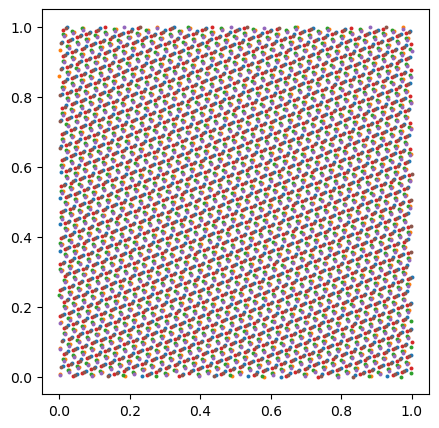

In [97]:
## korobov grid over 2d (from Art Owen Practical qMC integration 2023) 
d = 2
n = 1021
a = 76
basis = gen_korobov_basis(a=a,d=d,n=n)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for _ in range(6):
    
    pts = (torch.rand(1, d) + basis) % 1
    #pts = base_pts % 1
    ax.scatter(pts[:, 0], pts[:, 1], lw=0, s=8)
plt.show()
plt.close()
#fig, ax = plt.subplots(1, 1, figsize=(5, 5))
#for _ in range(6):
    
#    pts = (torch.rand(1, d) + basis) % 1
#    #pts = base_pts % 1
#    ax.scatter(pts[:, 0], pts[:, 2], lw=0, s=8)
#plt.show()
#plt.close()

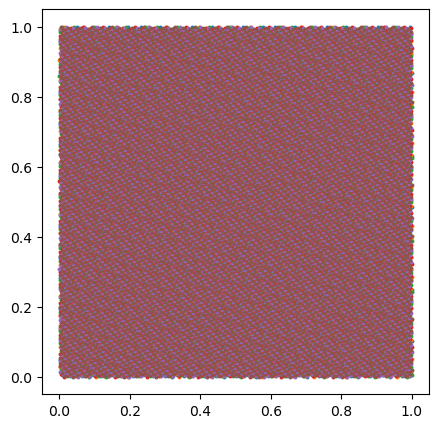

In [99]:
m = 20
## fibonacci grid over 2d (from Art Owen Practical qMC integration 2023) 
basis = gen_fib_basis(m)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for _ in range(6):
    
    pts = (torch.rand(1, 2) + basis) % 1
    #pts = base_pts % 1
    ax.scatter(pts[:, 0], pts[:, 1], lw=0, s=8)
plt.show()
plt.close()

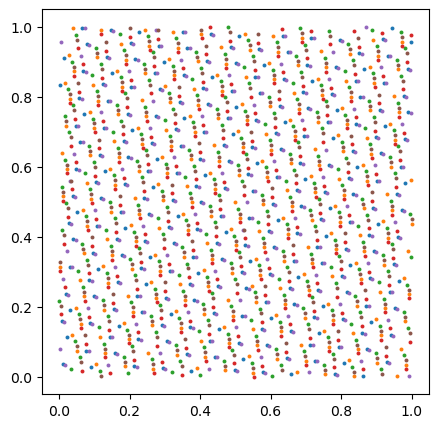

In [7]:
n = 2 ** 8
basis = roberts_sequence(n,num_dims=2)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for _ in range(6):
    pts = (torch.rand(1, 2) + basis) % 1
    #pts = basis % 1
    ax.scatter(pts[:, 0], pts[:, 1], lw=0, s=8)

In [18]:
class FourierBasis(nn.Module):

    def __init__(self, num_dims=2, num_freqs=4, device=None):
        super(FourierBasis, self).__init__()

        # F.shape == (num_dims x num_basis_functions)
        self.F = 2 * torch.pi * (
            torch.stack(
                torch.meshgrid(
                    [torch.arange(num_freqs)] * num_dims, indexing="ij"
                )
            ).reshape(
                num_dims, num_freqs ** num_dims
            )
        ).to(device)
        # self.wsin = nn.Parameter(torch.ones(num_freqs ** num_dims))
        # self.wcos = nn.Parameter(torch.ones(num_freqs ** num_dims))

    def forward(self, x):
        """
        x.shape == (batch_size, num_dims)
        """
        return torch.hstack(
            (torch.sin(x @ self.F), torch.cos(x @ self.F))
        )

class QMCLVM(nn.Module):
    def __init__(self, latent_dim=2, root_iters=100000, num_freqs=16, device=None):
        super(QMCLVM, self).__init__()

        self.latent_dim = latent_dim
        self.fourier_basis = FourierBasis(
            num_dims=latent_dim, num_freqs=num_freqs, device=device
        )

        # Decoder.
        #nn.Unflatten(1, (64, 7, 7)),
        #nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
        #nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
        #self.fourier_basis,
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim,2*num_freqs ** latent_dim),
            nn.Linear(2 * num_freqs ** latent_dim, 64*7*7),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), #nn.Linear(64*7*7,32*14*14),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),#nn.Linear(32*14*14,1*28*28),
            nn.Sigmoid(),
            #nn.Unflatten(1,(1,28,28))
        ).to(device)

    def forward(self, eval_grid):
        r = torch.rand(1, self.latent_dim, device=eval_grid.device)
        x = (r + eval_grid) % 1
        return self.decoder(x)

    def latent_density(self,eval_grid,sample,batch_size=-1):

        decoded = self.decoder(eval_grid %1)
        if batch_size == -1:
            batch_size = sample.shape[0]

        binom_lps = []
        for on in range(0,sample.shape[0],batch_size):
            off = on + batch_size
            
            s = sample[on:off].tile(1,decoded.shape[0],1,1)
            d = decoded.swapaxes(0,1).tile(s.shape[0],1,1,1)
            
            binomLP = -1 * binary_cross_entropy(d,
                                                s,
                                                reduction='none'
                                               ).sum(axis=(2,3))
            binom_lps.append(binomLP)
        binom_lps = torch.cat(binom_lps,axis=0)
        return binom_lps
                        

In [9]:
def loss_function(samples, data):
    recon_loss = -1 * torch.mean(
        torch.special.logsumexp(
            torch.sum(
                -1 * binary_cross_entropy(
                    samples.swapaxes(0, 1).tile((data.shape[0], 1, 1, 1)),
                    data.tile(1, samples.shape[0], 1, 1),
                    reduction="none"
                ),
                axis=(2, 3)
            ),
            axis=1
        )
    )
    return recon_loss

# def loss_function(samples, data):
#     return torch.mean(
#         torch.special.logsumexp(
#             torch.sum(
#                 (samples.swapaxes(0, 1).tile((data.shape[0], 1, 1, 1)) - data.tile(1, samples.shape[0], 1, 1)) ** 2,
#                 axis=(2, 3)
#             ),
#             axis=1
#         )
#     )

# Data loading
transform = transforms.ToTensor()
train_data = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

# Initialize model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = QMCLVM(latent_dim=2, num_freqs=16, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [100]:
from tqdm import tqdm
def train(epoch, base_sequence):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        optimizer.zero_grad()
        samples = model(base_sequence)
        loss = loss_function(samples, data)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch + 1} Average loss: {train_loss/len(train_loader.dataset):.4f}')


# Train for 20 epochs
train_base_sequence = gen_fib_basis(m=20)#gen_korobov_basis(a=76,d=2,n=1021)
model.train()
for epoch in range(50):
    train(epoch, train_base_sequence.to(device))

100%|██████████| 938/938 [00:27<00:00, 33.87it/s]


Epoch 1 Average loss: 2.0353


100%|██████████| 938/938 [00:27<00:00, 33.92it/s]


Epoch 2 Average loss: 2.0330


100%|██████████| 938/938 [00:27<00:00, 33.94it/s]


Epoch 3 Average loss: 2.0327


100%|██████████| 938/938 [00:27<00:00, 33.93it/s]


Epoch 4 Average loss: 2.0320


100%|██████████| 938/938 [00:27<00:00, 33.93it/s]


Epoch 5 Average loss: 2.0310


100%|██████████| 938/938 [00:27<00:00, 33.93it/s]


Epoch 6 Average loss: 2.0303


100%|██████████| 938/938 [00:27<00:00, 33.93it/s]


Epoch 7 Average loss: 2.0297


100%|██████████| 938/938 [00:27<00:00, 33.93it/s]


Epoch 8 Average loss: 2.0289


100%|██████████| 938/938 [00:27<00:00, 33.93it/s]


Epoch 9 Average loss: 2.0287


100%|██████████| 938/938 [00:27<00:00, 33.94it/s]


Epoch 10 Average loss: 2.0281


100%|██████████| 938/938 [00:27<00:00, 33.93it/s]


Epoch 11 Average loss: 2.0276


100%|██████████| 938/938 [00:27<00:00, 33.96it/s]


Epoch 12 Average loss: 2.0274


100%|██████████| 938/938 [00:27<00:00, 33.96it/s]


Epoch 13 Average loss: 2.0263


100%|██████████| 938/938 [00:27<00:00, 33.96it/s]


Epoch 14 Average loss: 2.0256


100%|██████████| 938/938 [00:27<00:00, 33.99it/s]


Epoch 15 Average loss: 2.0251


100%|██████████| 938/938 [00:27<00:00, 34.00it/s]


Epoch 16 Average loss: 2.0257


100%|██████████| 938/938 [00:27<00:00, 34.00it/s]


Epoch 17 Average loss: 2.0245


100%|██████████| 938/938 [00:27<00:00, 34.00it/s]


Epoch 18 Average loss: 2.0234


100%|██████████| 938/938 [00:27<00:00, 34.00it/s]


Epoch 19 Average loss: 2.0233


100%|██████████| 938/938 [00:27<00:00, 33.98it/s]


Epoch 20 Average loss: 2.0228


100%|██████████| 938/938 [00:27<00:00, 33.97it/s]


Epoch 21 Average loss: 2.0232


100%|██████████| 938/938 [00:27<00:00, 33.98it/s]


Epoch 22 Average loss: 2.0210


100%|██████████| 938/938 [00:27<00:00, 34.00it/s]


Epoch 23 Average loss: 2.0211


100%|██████████| 938/938 [00:27<00:00, 34.00it/s]


Epoch 24 Average loss: 2.0212


100%|██████████| 938/938 [00:27<00:00, 34.00it/s]


Epoch 25 Average loss: 2.0206


100%|██████████| 938/938 [00:27<00:00, 34.00it/s]


Epoch 26 Average loss: 2.0199


100%|██████████| 938/938 [00:27<00:00, 34.01it/s]


Epoch 27 Average loss: 2.0199


100%|██████████| 938/938 [00:27<00:00, 34.01it/s]


Epoch 28 Average loss: 2.0192


100%|██████████| 938/938 [00:27<00:00, 34.00it/s]


Epoch 29 Average loss: 2.0194


100%|██████████| 938/938 [00:27<00:00, 34.02it/s]


Epoch 30 Average loss: 2.0182


100%|██████████| 938/938 [00:27<00:00, 34.01it/s]


Epoch 31 Average loss: 2.0177


100%|██████████| 938/938 [00:27<00:00, 34.02it/s]


Epoch 32 Average loss: 2.0176


100%|██████████| 938/938 [00:27<00:00, 34.01it/s]


Epoch 33 Average loss: 2.0176


100%|██████████| 938/938 [00:27<00:00, 34.02it/s]


Epoch 34 Average loss: 2.0168


100%|██████████| 938/938 [00:27<00:00, 34.01it/s]


Epoch 35 Average loss: 2.0167


100%|██████████| 938/938 [00:27<00:00, 34.01it/s]


Epoch 36 Average loss: 2.0166


100%|██████████| 938/938 [00:27<00:00, 34.01it/s]


Epoch 37 Average loss: 2.0162


100%|██████████| 938/938 [00:27<00:00, 34.02it/s]


Epoch 38 Average loss: 2.0158


100%|██████████| 938/938 [00:27<00:00, 34.02it/s]


Epoch 39 Average loss: 2.0155


100%|██████████| 938/938 [00:27<00:00, 34.02it/s]


Epoch 40 Average loss: 2.0152


100%|██████████| 938/938 [00:27<00:00, 34.03it/s]


Epoch 41 Average loss: 2.0148


100%|██████████| 938/938 [00:27<00:00, 34.01it/s]


Epoch 42 Average loss: 2.0143


100%|██████████| 938/938 [00:27<00:00, 34.02it/s]


Epoch 43 Average loss: 2.0138


100%|██████████| 938/938 [00:27<00:00, 34.02it/s]


Epoch 44 Average loss: 2.0131


100%|██████████| 938/938 [00:27<00:00, 34.01it/s]


Epoch 45 Average loss: 2.0135


100%|██████████| 938/938 [00:27<00:00, 34.02it/s]


Epoch 46 Average loss: 2.0134


100%|██████████| 938/938 [00:27<00:00, 34.04it/s]


Epoch 47 Average loss: 2.0128


100%|██████████| 938/938 [00:27<00:00, 34.06it/s]


Epoch 48 Average loss: 2.0122


100%|██████████| 938/938 [00:27<00:00, 34.06it/s]


Epoch 49 Average loss: 2.0121


100%|██████████| 938/938 [00:27<00:00, 34.07it/s]

Epoch 50 Average loss: 2.0125


In [101]:
# Generate new samples
import matplotlib as mpl
n_samples_dim = 10
n_samples=n_samples_dim**2
cmap=mpl.colormaps['plasma']
norm = mpl.colors.Normalize(-1,n_samples)
with torch.no_grad():
    #z = torch.rand(n_samples, 2).to(device)
    xx,yy = torch.meshgrid([torch.arange(int(np.sqrt(n_samples)))/int(np.sqrt(n_samples))]*2,indexing='ij')
    z = torch.stack([xx.flatten(),yy.flatten()],axis=-1).to(device)
    sample = model.decoder(z).detach().cpu()
z = z.detach().cpu().numpy()
inds = np.arange(n_samples)
cs = cmap(norm(inds))

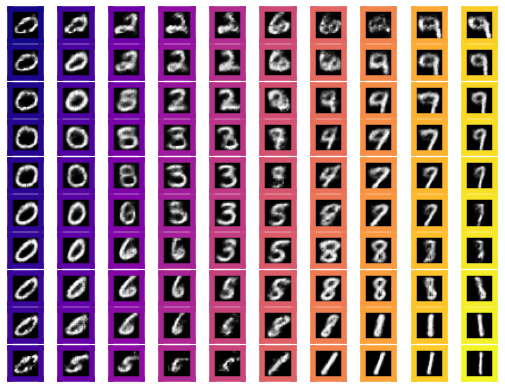

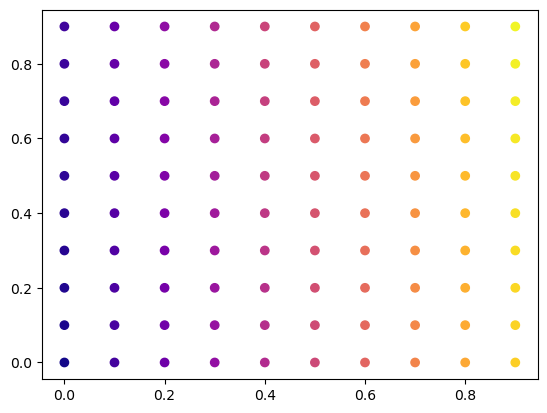

In [102]:
fig, axes = plt.subplots(n_samples_dim, n_samples_dim, sharey=True, sharex=True)

for i, ax in enumerate(axes.T.ravel()):
    ax.imshow(sample[i, 0, :, :], cmap='grey')
    ax.spines[['right','left','top','bottom']].set_color(cmap(norm(i)))
    ax.spines[['right','left','top','bottom']].set_linewidth(4)
    
axes[0, 0].set_xticks([])
axes[0, 0].set_yticks([])
plt.show()
plt.close()

ax = plt.gca()
ax.scatter(z[:,0],z[:,1],c=cs)
plt.show()
plt.close()

In [103]:
test_data = datasets.MNIST('./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)


In [104]:
def latent_density(model,eval_grid,sample,batch_size=-1):

        decoded = model.decoder(eval_grid %1)
        if batch_size == -1:
            batch_size = sample.shape[0]

        binom_lps = []
        for on in range(0,sample.shape[0],batch_size):
            off = on + batch_size
            
            s = sample[on:off].tile(1,decoded.shape[0],1,1)
            d = decoded.swapaxes(0,1).tile(s.shape[0],1,1,1)
            
            binomLP = -1 * binary_cross_entropy(d,
                                                s,
                                                reduction='none'
                                               ).sum(axis=(2,3))
            binom_lps.append(binomLP)
        binom_lps = torch.cat(binom_lps,axis=0)
        return binom_lps

In [105]:
d = 2
n = 2039
a = 1487
test_base_sequence = gen_korobov_basis(a=a,d=d,n=n)
plot_test_sequence = (test_base_sequence %1).detach().cpu().numpy()

data = test_loader.dataset.data.to(torch.float32)
labels = test_loader.dataset.targets.detach().cpu().numpy()
classes = np.unique(labels)
class_densities = {str(l):[] for l in classes}
class_images = {str(l):[] for l in classes}
for (sample,label) in test_loader:

    label = str(label.detach().cpu().numpy().squeeze())
    #print(label)
    log_density = latent_density(model,test_base_sequence.to(device),sample.to(device),batch_size=1).detach().cpu().numpy()
    class_densities[label].append(log_density)
    class_images[label].append(sample.detach().cpu().numpy().squeeze())

"""
ax = plt.gca()
g = ax.scatter(plot_test_sequence[:,0],plot_test_sequence[:,1],c=avg_log_density,cmap='plasma',vmin=-1000,vmax=0)
ax.set_title(f"log density for test {label}")
plt.colorbar(g,ax=ax)
plt.show()
plt.close()
"""

'\nax = plt.gca()\ng = ax.scatter(plot_test_sequence[:,0],plot_test_sequence[:,1],c=avg_log_density,cmap=\'plasma\',vmin=-1000,vmax=0)\nax.set_title(f"log density for test {label}")\nplt.colorbar(g,ax=ax)\nplt.show()\nplt.close()\n'

In [106]:
class_densities = {c: np.concatenate(class_densities[c],axis=0) for c in class_densities.keys()}
class_images = {c: np.stack(class_images[c],axis=0) for c in class_images.keys()}

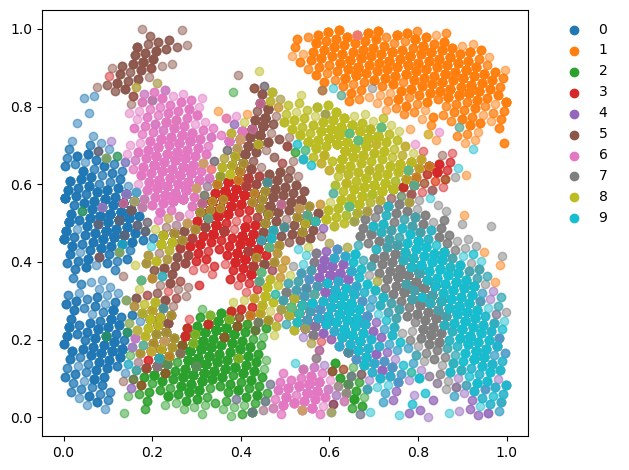

In [107]:
mosaic = [['0','0','1','1','2','2','3','3','4','4','cb'],
 ['5','5','6','6','7','7','8','8','9','9','cb']]
#fig, axs = plt.subplot_mosaic(mosaic,figsize=(15,5))
categorical_cmap = mpl.colormaps['tab10']
fig,axs = plt.subplots(nrows=1,ncols=2,width_ratios=(8,1))
ls = []
for c in class_densities.keys():
    dens = class_densities[c]
    class_maxs = np.argmax(dens,axis=1)
    #print(class_maxs)
    avg_dens = np.nanmean(dens,axis=0)
    #ax = plt.gca()
    #g=axs[c].scatter(plot_test_sequence[:,0],plot_test_sequence[:,1],c=avg_dens,vmin=-1200,vmax=-200)
    l = axs[0].scatter(plot_test_sequence[class_maxs,0],plot_test_sequence[class_maxs,1],color=categorical_cmap(int(c)),alpha=0.5,label=c)
    ls.append(l)
    #ax.set_title(f"{c}")
#fig.suptitle("Average log density across all test samples")    
#fig.suptitle("Distribution of projections for each class")    
#cb = plt.colorbar(g,cax=axs['cb'])
leg = axs[1].legend(ls,class_densities.keys(),frameon=False)
for lh in leg.legend_handles: 
    lh.set_alpha(1)
axs[1].spines[['top','right','left','bottom']].set_visible(False)
axs[1].set_xticks([])
axs[1].set_yticks([])
plt.tight_layout()
plt.show()
plt.close()

## individual sample plots

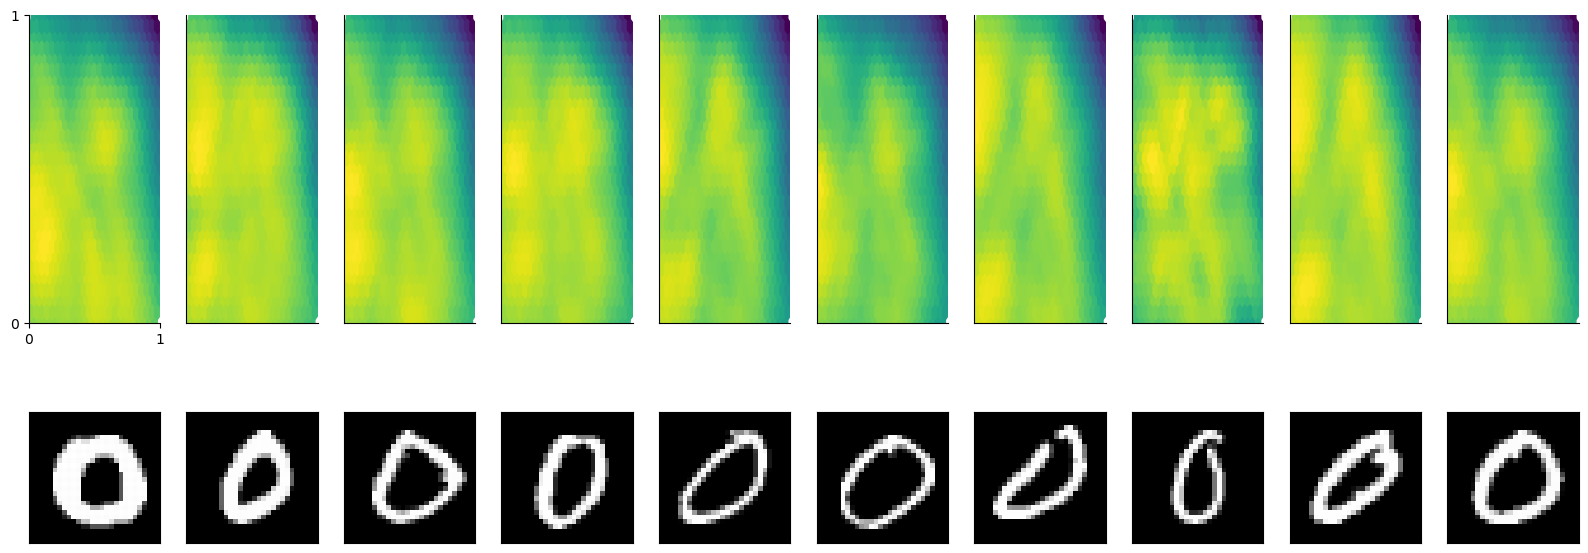

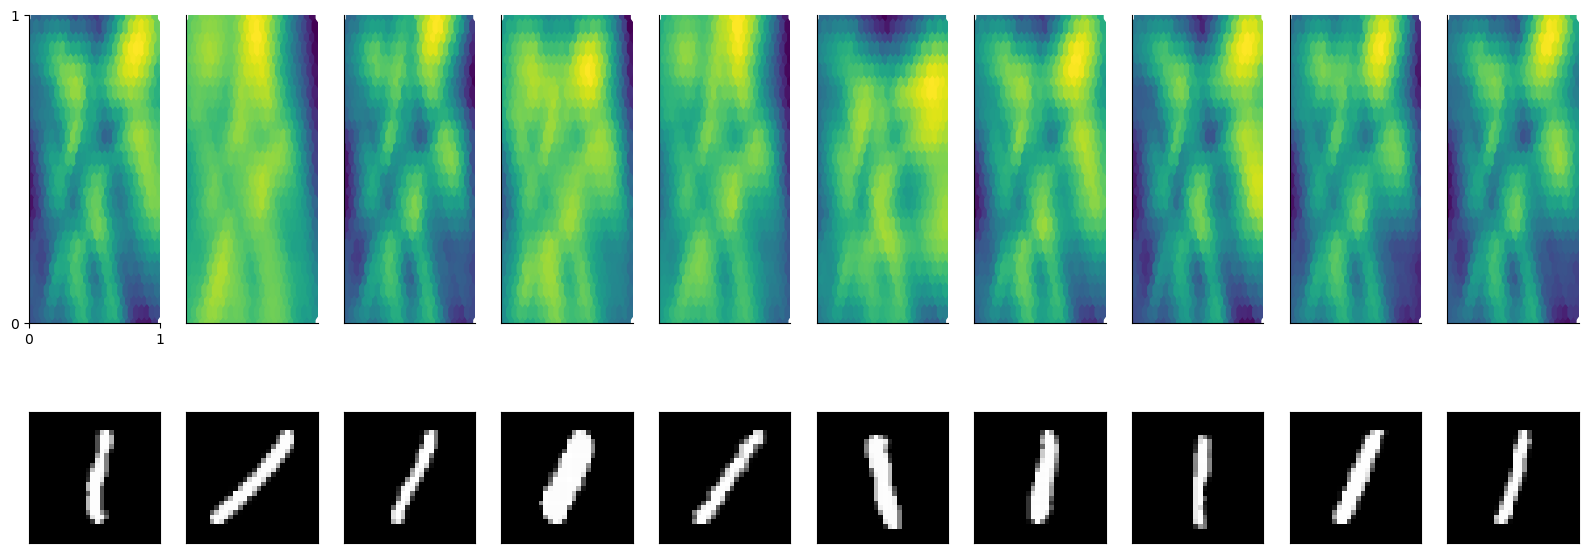

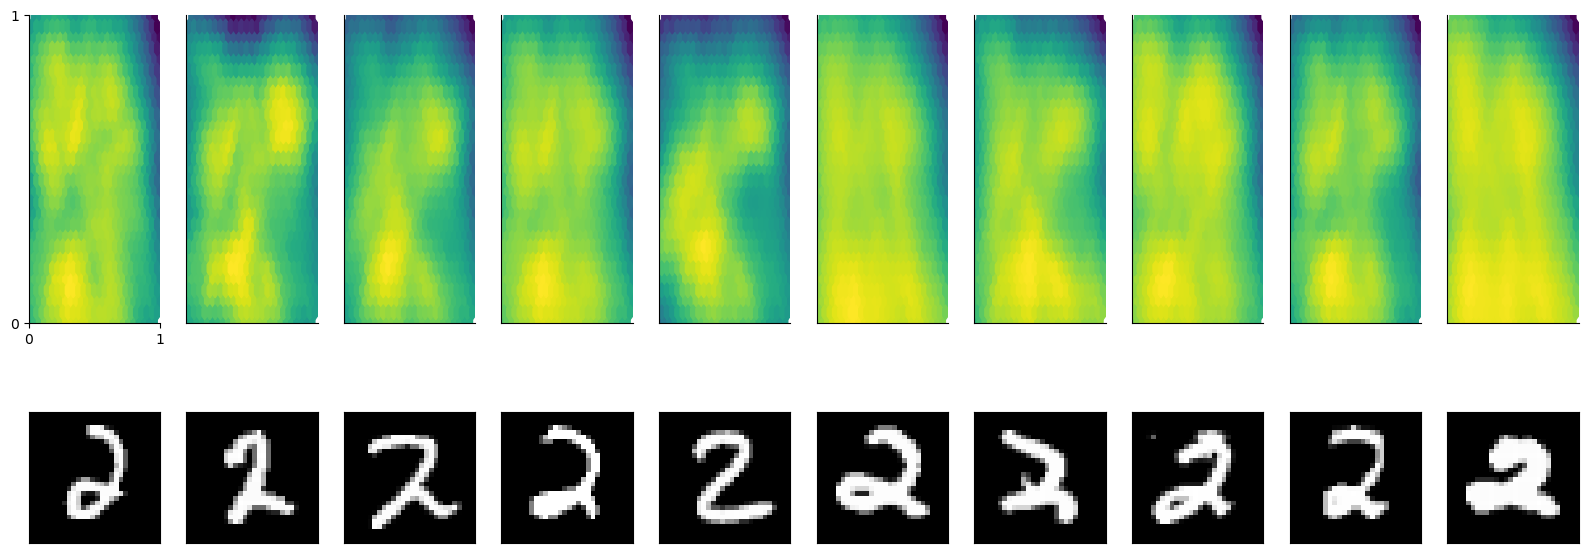

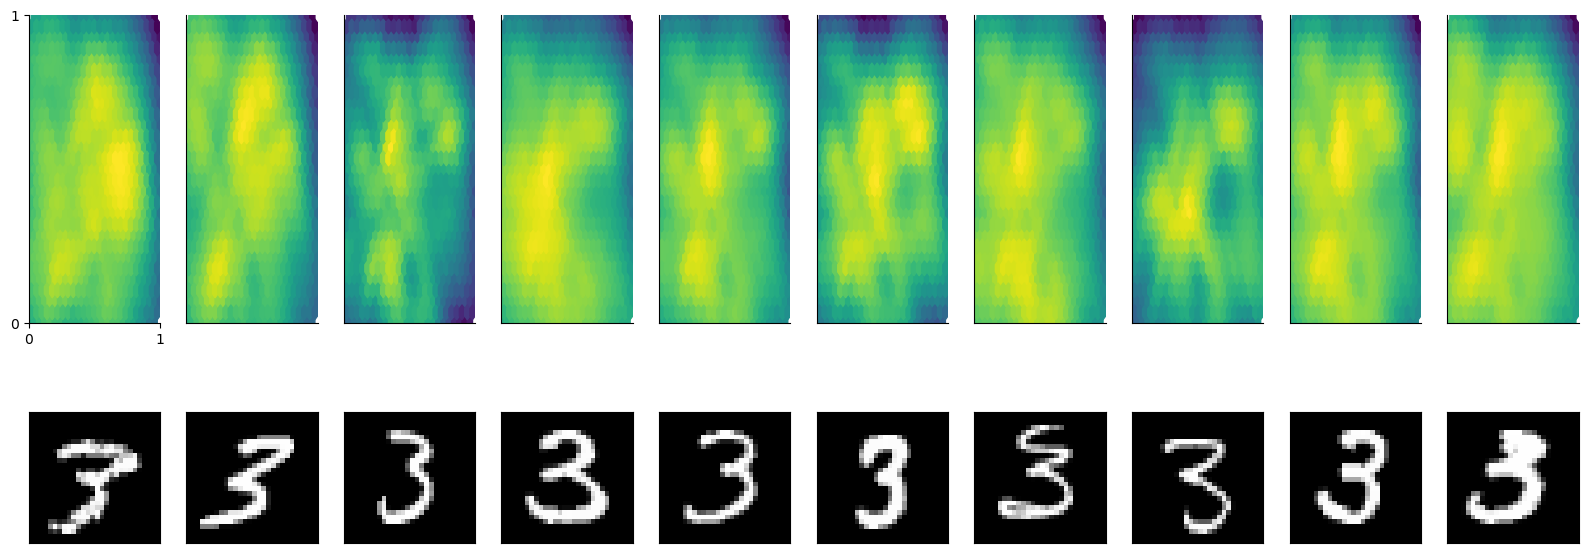

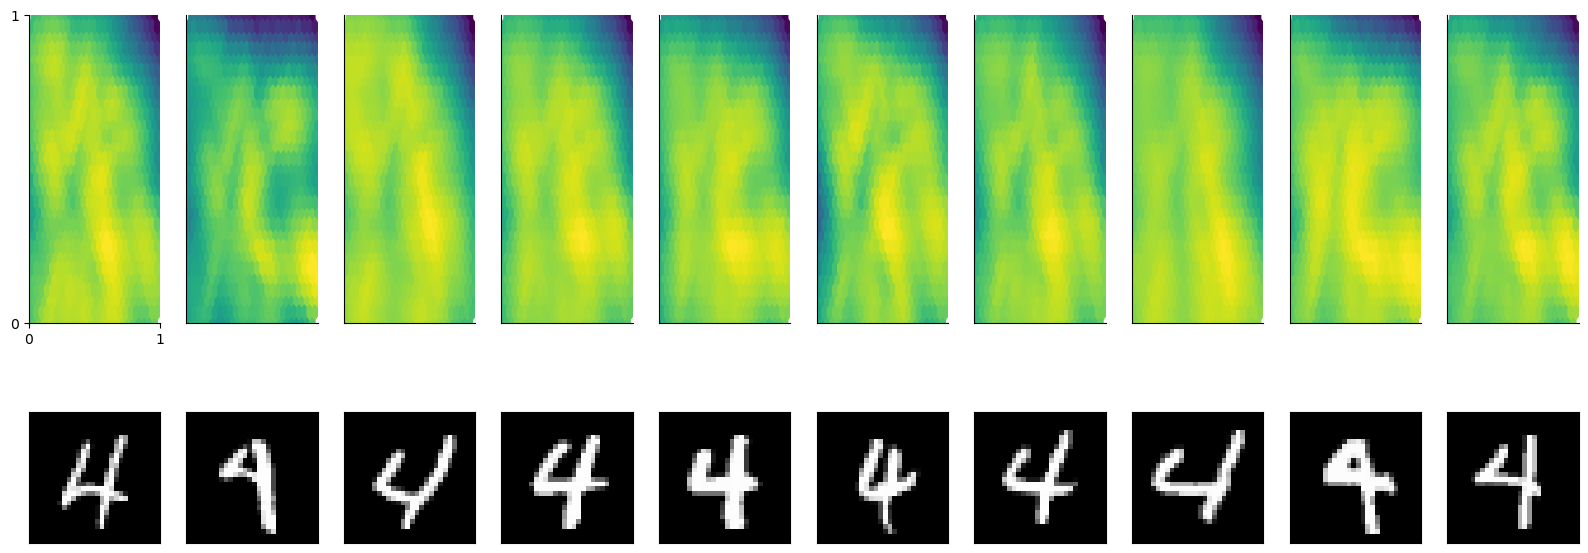

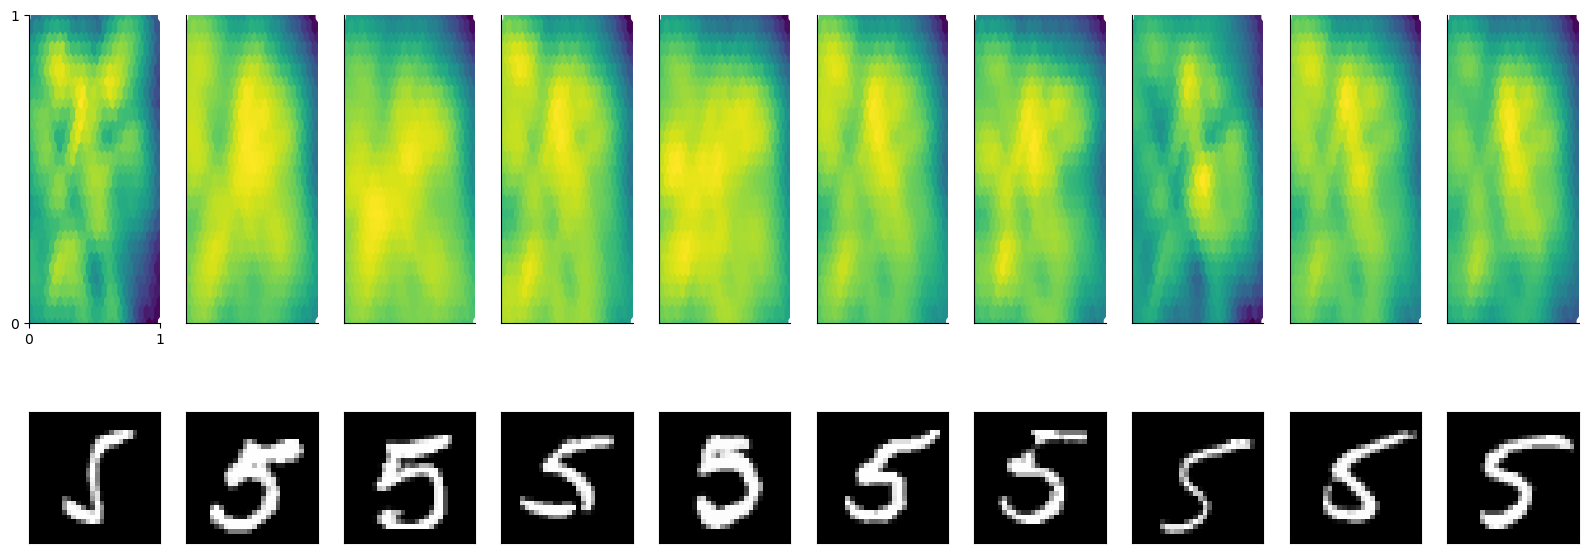

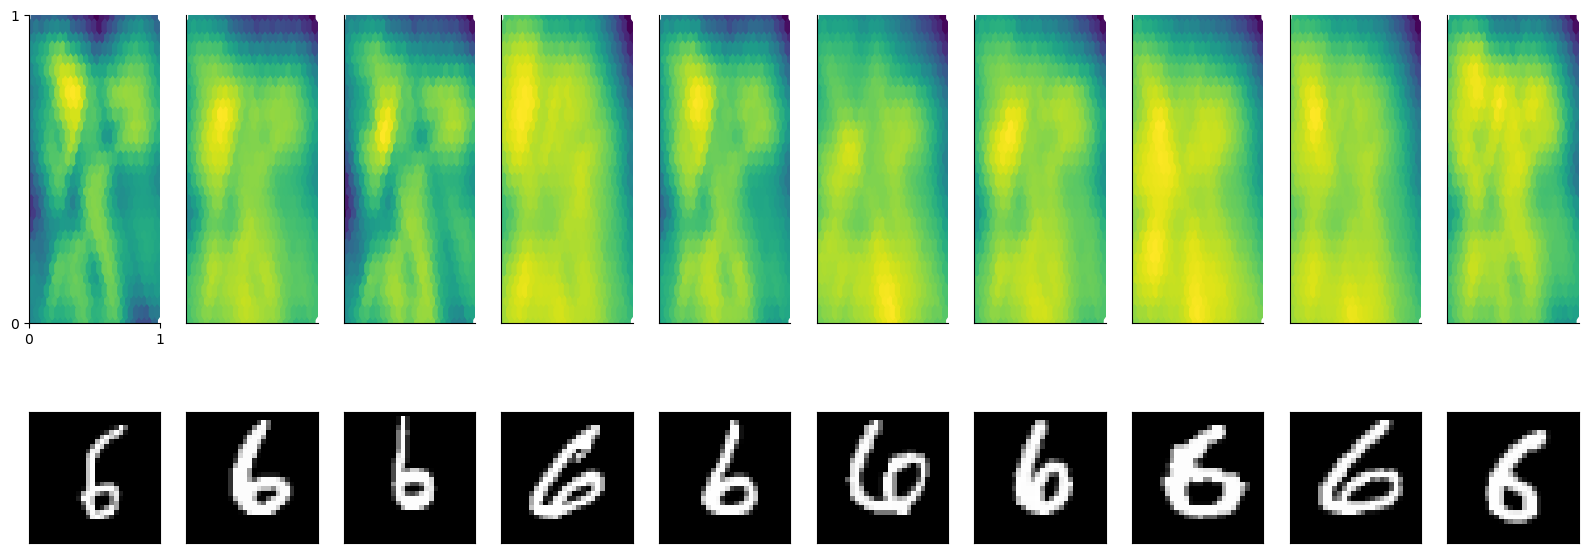

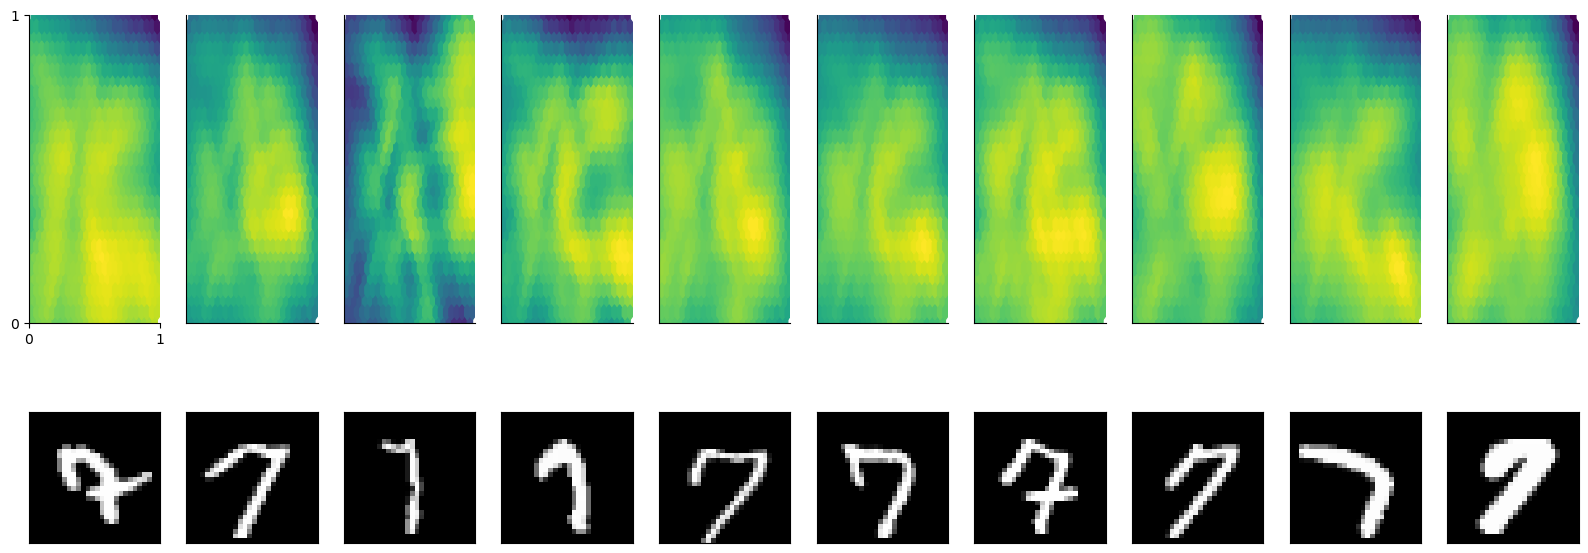

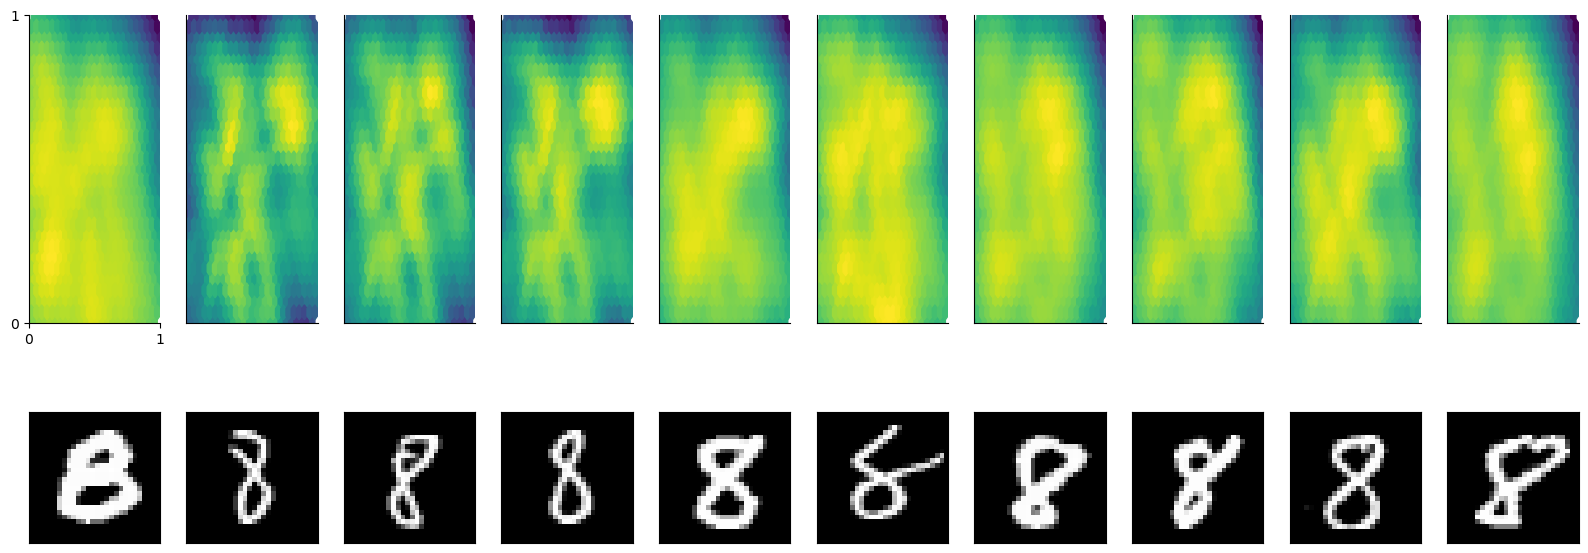

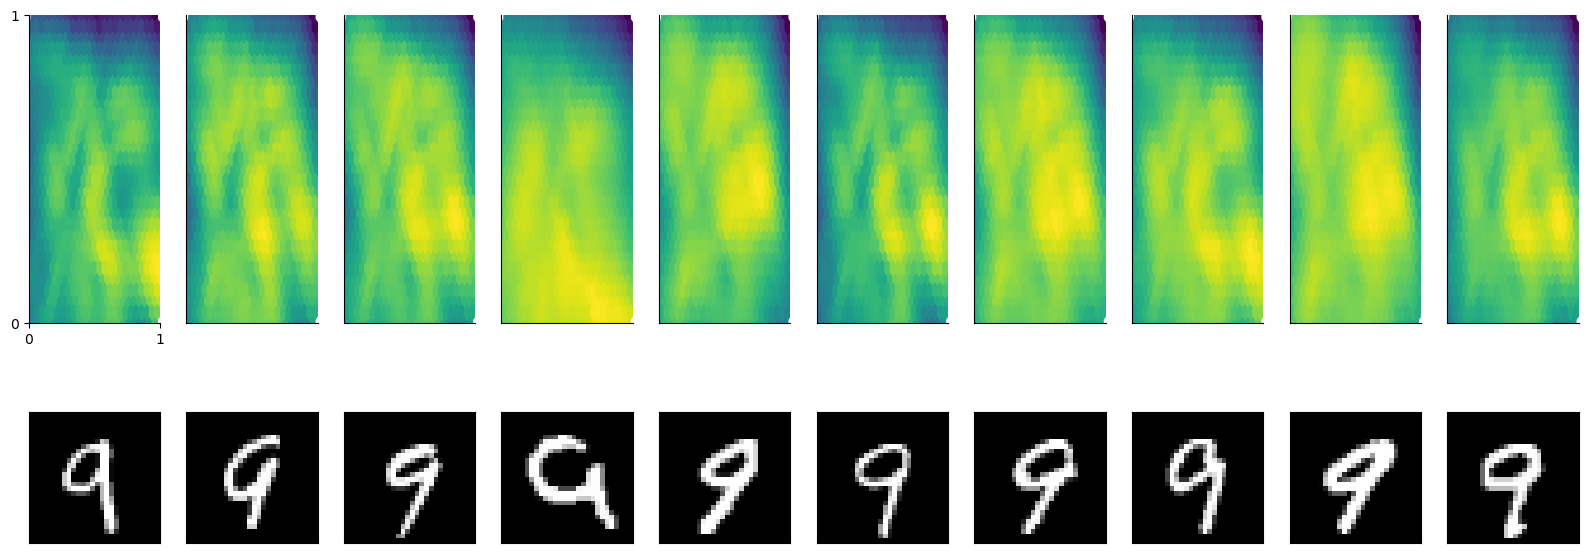

In [108]:
n_samples=10

for c in class_densities.keys():

    dens = class_densities[c]
    ims = class_images[c]
    vmin = np.amin(dens)
    vmax = np.amax(dens)
    
    ss = np.random.choice(len(dens),n_samples,replace=False)
    fig,axs = plt.subplots(nrows=2,ncols=n_samples,figsize=(20,8))
    for ii,(s,ax,ax2) in enumerate(zip(ss,axs[0,:],axs[1,:])):
        #fig,(ax,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
        #ax.scatter(plot_test_sequence[:,0],plot_test_sequence[:,1],c=dens[s])
        ax.hexbin(plot_test_sequence[:,0],plot_test_sequence[:,1],C=dens[s],gridsize=25)
        ax.spines[['right','top']].set_visible(False)
        ax2.imshow(ims[s],cmap='gray')
        ax2.set_xticks([])
        ax2.set_yticks([])
        ax.set_ylim([0,1])
        ax.set_xlim([0,1])
        if ii == 0:
            ax.set_yticks([0,1])
            ax.set_xticks([0,1])
        else:
            ax.set_yticks([])
            ax.set_xticks([])
    plt.subplots_adjust(hspace=0.0)   
    plt.show()
    plt.close()

In [81]:
import matplotlib as mpl
cmap=mpl.colormaps['plasma']
norm = mpl.colors.Normalize(0,64)
cmap(norm(63))

(0.946602, 0.95519, 0.150328, 1.0)